# Ensemble Model - EDP

### Author - Shaurya Singh Srinet and Charvi Jain

### Importing required libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow_addons.metrics import F1Score
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

C:\Users\Shaurya\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Reading input data

In [2]:
# Set your data directory
data_dir = "C:/Users/Shaurya/Downloads/dataset"

### Data Preprocessing

In [3]:
# Function to load and preprocess data
def load_and_preprocess_data(data_dir, img_size):
    class_names = ['normal', 'glaucoma', 'diabetic_retinopathy', 'cataract']
    filepaths = []
    labels = []

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        for filename in tqdm(os.listdir(class_path), ncols=110, desc=class_name, unit='file', colour='blue'):
            filepath = os.path.join(class_path, filename)
            img = cv2.imread(filepath)
            img = cv2.resize(img, img_size)  # Resize image to desired dimensions
            filepaths.append(filepath)
            labels.append(class_name)

    df = pd.DataFrame({"filepaths": filepaths, "labels": labels})

    # Split the data into training and testing sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=123, stratify=df['labels'])

    return train_df, test_df, class_names  # Return class_names

# Load and preprocess your data
train_df, test_df, class_names = load_and_preprocess_data(data_dir, img_size=(224, 224))


cataract: 100%|████████████████████████████████████████████████████████| 1033/1033 [00:06<00:00, 166.02file/s]


### Defining batch size and image dimensions

In [4]:
batch_size = 64
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)

### Creating Data using ImageGenerator

In [5]:
# Function to create data generators
def create_data_generators(train_df, test_df, img_size, batch_size):
    train_datagen = ImageDataGenerator(rescale=1/255.0, rotation_range=20, vertical_flip=True, shear_range=0.2, dtype=float)
    test_datagen = ImageDataGenerator(rescale=1/255.0, dtype=float)

    train_set = train_datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)
    test_set = test_datagen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)

    return train_set, test_set

In [6]:
# Create data generators
train_set, test_set = create_data_generators(train_df, test_df, (img_height, img_width), batch_size)

Found 3369 validated image filenames belonging to 4 classes.
Found 843 validated image filenames belonging to 4 classes.


### Defining the Xception model

In [7]:
def generate_xception_model(input_shape, num_classes):
    xception_base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(xception_base.output)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=xception_base.input, outputs=predictions)

    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', F1Score(num_classes=num_classes)])
    
    return model

### Generating the Xception model

In [8]:
num_classes = len(class_names)
xception_model = generate_xception_model(input_shape, num_classes)

In [9]:
# Display model summary
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

### Training the model

In [10]:
epochs = 10
history = xception_model.fit(train_set, epochs=epochs, validation_data=test_set)

Epoch 1/10
53/53 [==============================] - 629s 12s/step - loss: 0.5464 - accuracy: 0.7970 - f1_score: 0.7949 - val_loss: 11.8330 - val_accuracy: 0.4816 - val_f1_score: 0.3502
Epoch 2/10
53/53 [==============================] - 577s 11s/step - loss: 0.3297 - accuracy: 0.8789 - f1_score: 0.8769 - val_loss: 1.0910 - val_accuracy: 0.6904 - val_f1_score: 0.6411
Epoch 3/10
53/53 [==============================] - 568s 11s/step - loss: 0.2670 - accuracy: 0.9127 - f1_score: 0.9112 - val_loss: 1.0714 - val_accuracy: 0.7877 - val_f1_score: 0.7879
Epoch 4/10
53/53 [==============================] - 568s 11s/step - loss: 0.2427 - accuracy: 0.9104 - f1_score: 0.9084 - val_loss: 0.3049 - val_accuracy: 0.9158 - val_f1_score: 0.9147
Epoch 5/10
53/53 [==============================] - 572s 11s/step - loss: 0.1880 - accuracy: 0.9323 - f1_score: 0.9314 - val_loss: 0.2829 - val_accuracy: 0.9170 - val_f1_score: 0.9146
Epoch 6/10
53/53 [==============================] - 570s 11s/step - loss: 0.169

### Saving the trained model

In [15]:
xception_model.save('xception_model.h5')
print("Model saved successfully.")

C:\Users\Shaurya\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


### Evaluating the model on the test set

In [16]:
evaluation = xception_model.evaluate(test_set)

14/14 [==============================] - 24s 2s/step - loss: 0.3567 - accuracy: 0.9122 - f1_score: 0.9081


In [17]:
# Print evaluation results
print("\nEvaluation Results:")
print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]*100:.2f}%")


Evaluation Results:
Test Loss: 0.3567
Test Accuracy: 91.22%


### Plotting training history

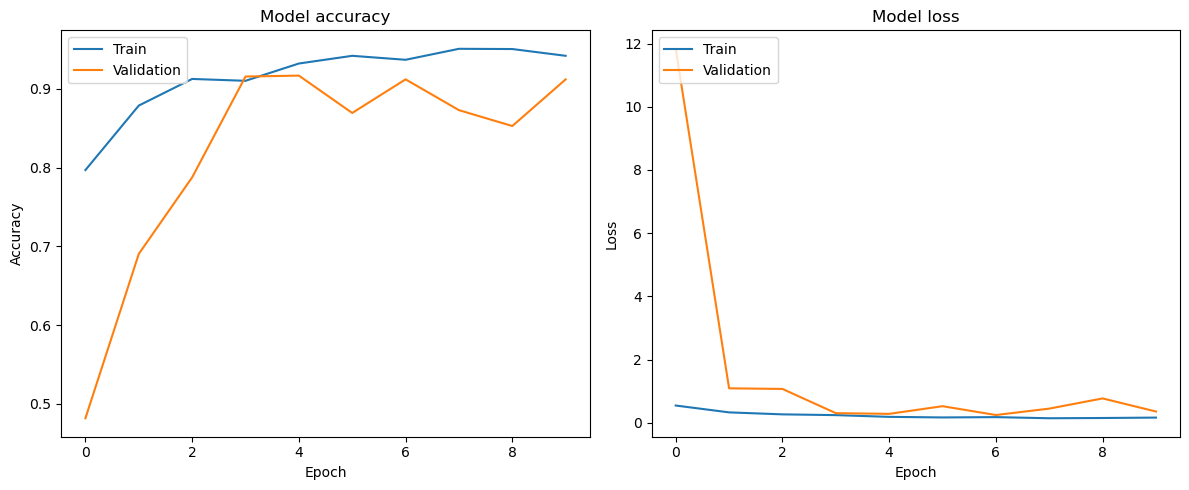

In [21]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])  # Use 'accuracy' instead of 'categorical_accuracy'
    plt.plot(history.history['val_accuracy'])  # Use 'val_accuracy' instead of 'val_categorical_accuracy'
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history)


### Generating predictions for the test set

In [22]:
predictions = xception_model.predict(test_set, steps=test_set.n // batch_size)

13/13 [==============================] - 33s 2s/step


In [25]:
# Use test_set.classes directly for class indices
y_true = test_set.classes
y_pred = np.argmax(predictions, axis=1)

### Ploting the confusion matrix

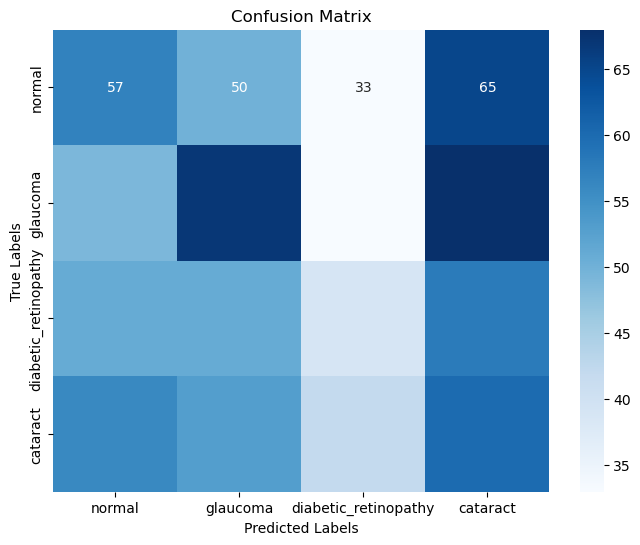

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### Generating and printing the classification report

In [44]:
# Use the original labels from the generator
test_true_labels = test_set.classes

# If the true labels are not one-hot encoded, convert them
if isinstance(test_true_labels[0], list):
    test_true_labels = np.argmax(test_true_labels, axis=1)

# Convert predictions to class labels
test_pred_labels = np.argmax(predictions, axis=1)

# Ensure both arrays have the same length
min_length = min(len(test_true_labels), len(test_pred_labels))
test_true_labels = test_true_labels[:min_length]
test_pred_labels = test_pred_labels[:min_length]

# Print the classification report
class_report = classification_report(test_true_labels, test_pred_labels, target_names=class_names)
print("Classification Report:\n", class_report)

Classification Report:
                       precision    recall  f1-score   support

              normal       0.27      0.28      0.27       205
            glaucoma       0.30      0.31      0.31       217
diabetic_retinopathy       0.27      0.20      0.23       199
            cataract       0.24      0.28      0.26       211

            accuracy                           0.27       832
           macro avg       0.27      0.27      0.27       832
        weighted avg       0.27      0.27      0.27       832

